# Analysis of individual datasets

In [1]:
import pandas as pd
import numpy as np
import ast
import json
import os
from df_utils import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os.path as path


In [2]:
import sys
print(sys.executable)

/home/cath/Downloads/s/envs/plexplain/bin/python


## Load data and define settings for plots

* df: all data
* df_model: solution and built furniture of the optimal solution
* df_vp_sol: solution of vps as saved in sosci survey
* df_actions: dataframe with alle actions 
* df_built: built items and furniture, no items where recorded as built in tutorial 
* df_resources: resources after each build-actions
* df_play_times: time used in month

In [3]:
# seaborn settings
sns.set(font_scale=2, style = 'white', palette = 'deep') 

In [4]:
# get data csv
cur_dir =  os.getcwd() 
parent_dir = os.path.dirname(os.path.dirname(cur_dir))
data_file = 'data/online/full_experiment/data_furnituremanufacturing_2021-08-11_09-15.csv'
data_path = os.path.join(parent_dir, data_file)

# transform to dataframe
df, df_model, _, df_vp_sol, _, df_actions, df_built, df_resources, df_play_times = decompose_csv(data_path)



read cache


In [5]:
vp = 161
df_sol = pd.DataFrame(df_vp_sol[df_vp_sol.index == vp].filter(regex='PL01').values, columns = list(range(1,13)))
df_sol

,1,2,3,4,5,6,7,8,9,10,11,12
0,28.0,18.0,27.0,23.0,33.0,25.0,29.0,32.0,45.0,37.0,48.0,51.0


## Function for basic measurements
* Profit per month
* Difference to optimal solution
* Play time per month (without questions)

In [6]:
def plot_basic_statistics(vp, df_vp_sol, df_model, df_play_times):
    '''Plots Profit, Difference to optimal solution & playing times''' 
    
    fig = plt.figure(figsize=(18, 15))
    fig.subplots_adjust(bottom=0.25, left=0.025, top = 0.975, right=0.975)   
    fig.tight_layout()

    # profit over months
    sub = fig.add_subplot(2,1,1)
    sub.title.set_text('Profit reached by vp ' + str(vp)+ ' in each month')


    df_sol = pd.DataFrame(df_vp_sol[df_vp_sol.index == vp].filter(regex='PL01').values, columns = list(range(1,13)))
    df_sol.columns.name = 'month'
    df_sol = df_sol.melt(value_name = 'solutions', ignore_index=True)#
    g =sns.lineplot(data = df_sol[df_sol.month >0],x='month', y = 'solutions', ax = sub, color = 'darkgreen')
    sns.scatterplot(data = df_sol[df_sol.month >0],x='month', y = 'solutions',ax = sub, color = 'darkgreen', s =80)
    scatter = sns.scatterplot(x=list(range(1,13)),y=df_model.filter(regex = 'MD01').iloc[0], s=80,  
                              linewidth = 2,  marker = "+", color = 'black', ax = sub)

    xlabel = plt.xlabel('Month', fontsize = 17)
    ylabel = plt.ylabel('Profit', fontsize = 17)
    sub.set_ylim([12,68])

    # difference to optimal
    sub1 = fig.add_subplot(2,2,3)
    sub1.title.set_text('Percentage under optimal solution vp ' + str(vp))

    difference = ((df_vp_sol.filter(regex='PL01').values/df_model.filter(regex = 'MD01').iloc[0].values)-1)*100
    df_diff = pd.DataFrame(difference, columns = list(range(1,13)))
    df_diff = df_diff.set_index(df_vp_sol.index.unique())
    df_diff.columns.name = 'month'

    df_plot = df_diff.melt(value_name = 'difference', ignore_index=False)#
    sub1.axhline(0, color = 'gray')
    data = df_plot[df_plot.index == vp]
    data.index = range(len(data.index))
    sns.lineplot(data = data,x='month', y = 'difference',ax = sub1, color = 'orange')
    sns.scatterplot(data = df_plot[df_plot.index == vp],x='month', y = 'difference', ax = sub1, color = 'orange',
                    s =80)

    xlabel = plt.xlabel('Month', fontsize = 17)
    ylabel = plt.ylabel('Percentage under optimal', fontsize = 17)
    sub1.set_ylim([-80,1])

    # times
    sub2 = fig.add_subplot(2,2,4)   
    sub2.title.set_text('Playing times in each month')
    data = df_play_times[(df_play_times.index == vp) &(df_play_times.month > 0) ].reindex()
    data.index = range(len(data.index))
    # sub2.title('Playing times in each month', fontsize = 20)
    sns.lineplot(data = data,x='month', y = 'minutes', 
                 color = 'darkblue', ax = sub2)
    sns.scatterplot(data =data ,x='month', y = 'minutes', ax = sub2, s =80)
    sub2.axhline(3, color = 'sienna')
    xlabel = plt.xlabel('Month', fontsize = 17)
    ylabel = plt.ylabel('Time in Minutes', fontsize = 17)
    sub2.set_ylim([0,3.5])
    fig.savefig('Images/vp_'+str(vp) + '/basic_stats_vp_' + str(vp) +'.png',bbox_inches='tight')



In [7]:
vp = 222
df_sol = pd.DataFrame(df_vp_sol[df_vp_sol.index == vp].filter(regex='PL01').values, columns = list(range(1,13)))
difference = df_vp_sol.filter(regex='PL01').values -df_model.filter(regex = 'MD01').iloc[0].values
df_diff = pd.DataFrame(difference, columns = list(range(1,13)))
df_diff = df_diff.set_index(df_vp_sol.index.unique())
df_diff.columns.name = 'month'

df_plot = df_diff.melt(value_name = 'difference', ignore_index=False)#
print(df_plot[(df_plot.index == vp) & (df_plot.month > 2)].difference.mean())
df_plot[(df_plot.index == vp) & (df_plot.month > 2)].difference.std()


-2.4


1.577621275493231

## Action Trajectories

* General Actions
* Built parts and built full furniture

In [8]:
def plot_general_actions(vp, df_actions):
    '''All action typed in each month, frequency of actions grouped by types
        and the relation of the individual to the general distribution of actions''' 
    fig = plt.figure(figsize=(18, 28))
    fig.subplots_adjust(bottom=0.25, left=0.025, top = 0.975, right=0.975)   
    fig.tight_layout()
    # General action overview
    sub = fig.add_subplot(3,1,1)
    df_general = df_actions[(df_actions.action_type != 'close building') 
                        & (df_actions.action_type != 'sound')& (df_actions.action_type != 'warning')]
    order = df_general.action_type.unique()

    sub.set_title('General overview over actions all months ', fontweight='bold')

    g = sns.stripplot(data = df_general[(df_general['vp']==vp)],
              x= 'minutes', y = 'action_type', hue = 'action_type', order = order, s = 15 ,
                marker = '|', linewidth=2, jitter = False, ax = sub)
    monthly_start = df_actions[df_actions.vp == vp].groupby('month')['minutes'].min().values
    for m in range(1,13):
        sub.axvline(monthly_start[m], color = 'grey')
    g.get_legend().remove()
    xlabel = plt.xlabel('Minute in Game')
    ylabel = plt.ylabel('Action Type')
    # frequency
    sub1 = fig.add_subplot(3,1,2)
    df_general_freq = df_actions[(df_actions.action_type != 'close building') 
                        & (df_actions.action_type != 'sound')& (df_actions.action_type != 'warning')& 
                        (df_actions.action_type != 'question')& (df_actions.action_type != 'skipped')]

    sub1.set_title('Frequency of actions in each month ', fontweight='bold')
    counts= df_general_freq.groupby(['month','vp']).action_type.value_counts()
    counts = counts.reset_index(level='month')
    counts = counts.rename(columns = {'action_type': 'Frequency'})
    counts = counts.reset_index(level='action_type')
    order = counts.action_type.unique()
    f = sns.barplot(data = counts[counts.index == vp], 
                x='month', y='Frequency', hue = 'action_type', ax = sub1)
    xlabel = plt.xlabel('Month')
    f.legend(bbox_to_anchor=(0.95, 1.05), fontsize = 15)
    
    # relation to distribution
    sub2 = fig.add_subplot(3,1,3)
    sub2.set_title('Relation of vps action to the distribution of the total amount of action by all vps', fontweight='bold')

    df_sum = counts.groupby(['vp', 'action_type']).Frequency.sum().reset_index(name ='Total Frequency')
    g = sns.violinplot(data = df_sum, x = 'action_type', y = 'Total Frequency', order=order, inner = None, ax = sub2, cut = 0)
    sns.swarmplot(data = df_sum[df_sum.vp==vp], x='action_type', y= 'Total Frequency', ax = sub2, color = 'white' , order=order)
    xlabel = plt.xlabel('Action Type')
    
    fig.savefig('Images/vp_'+str(vp) + '/general_action_vp_'+str(vp) + '.png',bbox_inches='tight')




In [9]:
def furniture_overview(vp, df_built):
    '''Furniture parts and items built in whole experiment''' 

    fig = plt.figure(figsize=(23, 18))
    sub = fig.add_subplot(2,1,1)
    sub.set_title('Furniture parts built ', fontweight='bold')

    sns.set_style("ticks")
    order = ['shelf frame','shelf', 'bed frame', 'bed top', 'table leg', 'table top', 'chair leg', 'chair back' ]
    monthly_start = df_actions[df_actions.vp == vp].groupby('month')['minutes'].min().values

    g = sns.stripplot(data = df_built[(df_built['vp']==vp) & (df_built['useful']=='used')& (df_built['month']>0)],
                    x= 'minutes', 
                    y = 'furniture_parts', marker = 'd', order = order, jitter = False,

                    orient="h",  s = 12,linewidth=1,alpha = 0.6,dodge=True, ax = sub)

    sns.stripplot(data = df_built[(df_built['vp']==vp) & (df_built['useful']=='not used')& (df_built['month']>0)],
                    x= 'minutes', 
                    y = 'furniture_parts', marker = 'x', order = order,

                    orient="h",jitter = False, s = 15,linewidth=2,alpha = 0.8,

                     dodge=True, ax = sub)
    for m in range(1,13):
        plt.axvline(monthly_start[m], color = 'gray')
    legend_elements = [Line2D([], [], marker='d', color='b', label='used',linestyle='None',
                              markerfacecolor='b', markersize=10),
                       Line2D([], [], marker='x', color='b', label='not used',linestyle='None',
                              markerfacecolor='b', markersize=10)]
    sub.legend(handles=legend_elements, bbox_to_anchor=(0.95, 1.05))
    xlabel = plt.xlabel('Minutes')
    ylabel = plt.ylabel('Furniture parts')


    sub1 = fig.add_subplot(2,1,2)
    sub1.set_title('Full furniture items built ', fontweight='bold')

    order = ['Bookcase', 'Bed', 'Chair', 'Table']
    g = sns.stripplot(data = df_built[(df_built['vp']==vp) & (df_built['month']>0)],
                    x= 'minutes', 
                    y = 'full_furniture', marker = 'd', order = order,jitter = False,

                    orient="h",  s = 12,linewidth=1,alpha = 0.6,dodge=True, ax = sub1)
    for m in range(1,13):
        plt.axvline(monthly_start[m], color = 'gray')
    xlabel = plt.xlabel('Minutes')
    ylabel = plt.ylabel('Furniture')

    fig.savefig('Images/vp_'+str(vp) + '/built_furniture_overview_vp_'+str(vp) + '.png',bbox_inches='tight')


In [10]:
def plot_furniture(vp, df_built):
    '''Furniture items built in each moth''' 

    sns.set_style('ticks')
    fig, axes = plt.subplots(3, 4, sharey='row', figsize=(23, 15) )
    c1=0
    c2=0
    for m in range(1,13):
        order = ['Bookcase', 'Bed', 'Chair', 'Table']
        g = sns.stripplot(data = df_built[(df_built.month==m) &(df_built['vp']==vp) & (df_built.full_furniture != 'nothing' )],
                    x= 'minutes', 
                    y = 'full_furniture', marker = 'd', order = order,

                    orient="h",  jitter = False, s = 14,linewidth=1,alpha = 0.6,
                    dodge=True, ax = axes[c2,c1])
        g.set(xlabel=None, ylabel = None)

        if c1 <3:
            c1+=1
        else:
            c1 = 0
            c2 +=1
    for i, row in enumerate(axes):
        for j, cell in enumerate(row):
            if j == 0:
                cell.set_ylabel("Furniture\n Month {} - {}".format(i*4+1, (i+1)*4))
    title = fig.suptitle('Built furniture in each month by vp '+ str(vp))
    xlab = fig.text(0.5, 0.0, 'Minutes in Game', ha='center')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95, bottom = 0.06)
    fig.savefig('Images/vp_'+str(vp) + '/full_furniture_each_month_vp'+str(vp) + '.png',bbox_inches='tight')


In [11]:
def plot_furniture_parts(vp, df_built):
    '''Furniture parts built in each moth''' 
    sns.set_style('ticks')
    fig, axes = plt.subplots(3, 4, sharey='row', figsize=(23, 15) )
    c1=0
    c2=0
    order = ['shelf frame','shelf', 'bed frame', 'bed top', 'table leg', 'table top', 'chair leg', 'chair back' ]
    for m in range(1,13):

        g = sns.stripplot(data = df_built[(df_built.month==m) &(df_built['vp']==vp)],
                    x= 'minutes', 
                    y = 'furniture_parts', marker = 'd', order = order,

                    orient="h",  jitter = False, s = 14,linewidth=1,alpha = 0.6,
                    dodge=True, ax = axes[c2,c1])
        g.set(xlabel=None, ylabel = None)
        #axes[c2,c1].yaxis.grid(True)

        if c1 <3:
            c1+=1
        else:
            c1 = 0
            c2 +=1
    for i, row in enumerate(axes):
        for j, cell in enumerate(row):
            if j == 0:
                cell.set_ylabel("Furniture parts\n Month {} - {}".format(i*4+1, (i+1)*4))
    title = fig.suptitle('Built furniture parts in each month by vp '+ str(vp))
    xlab = fig.text(0.5, 0.0, 'Minutes in Game', ha='center')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95, bottom = 0.06)
    fig.savefig('Images/vp_'+str(vp) + '/furniture_parts_each_month_vp'+str(vp) + '.png',bbox_inches='tight')


## Resources
* material left after each decision
* workshop hours left after each decision

In [12]:
def plot_material(vp, df_resources):
    '''Material after each decision''' 
    sns.set_style('ticks')
    fig, axes = plt.subplots(3, 4, figsize=(23, 15), sharey = True)

    c1=0
    c2=0
    df_resources.minutes = pd.to_numeric(df_resources.minutes)

    for m in range(1,13):
        data_res=df_resources[(df_resources.vp == vp) &(df_resources.month == m) ]
        data_res = data_res.sort_values('timepoint')
        data_res.reset_index()
        axes[c2,c1].fill_between(data_res['minutes'], data_res['wood'], step="post", alpha=0.4)
        axes[c2,c1].fill_between(data_res['minutes'], data_res['metal'], step="post", alpha=0.4)
        axes[c2,c1].step(data_res['minutes'], data_res['wood'], where = 'post', label='wood')
        axes[c2,c1].step(data_res['minutes'], data_res['metal'], where = 'post',  label='metal')
        if c2+c1 == 0:
            axes[c2,c1].legend()
        if c1 <3:
            c1+=1
        else:
            c1 = 0
            c2 +=1
    title = fig.suptitle('Use of material in each month by vp '+ str(vp))
    xlab = fig.text(0.5, 0.0, 'Minutes in Game', ha='center')
    ylab = fig.text(-0.01, 0.5, 'Amount', ha='center')

    fig.tight_layout()
    fig.savefig('Images/vp_'+str(vp) + '/material_use_each_month_vp'+str(vp) + '.png',bbox_inches='tight')

#sns.plot(df_resources[(df_resources.vp == vp) &(df_resources.month == m) ].wood

In [13]:
def plot_workshops(vp, df_resources):
    '''Resources after each decision''' 
    sns.set_style('ticks')
    fig, axes = plt.subplots(3, 4, figsize=(23, 15), sharey = True)

    c1=0
    c2=0
    for m in range(1,13):
        data_res=df_resources[(df_resources.vp == vp) &(df_resources.month == m) ]
        data_res = data_res.sort_values('timepoint')
        data_res.reset_index()
        axes[c2,c1].fill_between(data_res['minutes'], data_res['wsA'], step="post", alpha=0.2, color = 'darkgreen')
        axes[c2,c1].fill_between(data_res['minutes'], data_res['wsB'], step="post", alpha=0.2, color = 'darkblue')
        axes[c2,c1].fill_between(data_res['minutes'], data_res['wsC'], step="post", alpha=0.2, color = 'darkorange')
        axes[c2,c1].fill_between(data_res['minutes'], data_res['wsD'], step="post", alpha=0.2, color = 'darkred')

        axes[c2,c1].step(data_res['minutes'], data_res['wsA'], where = 'post', label='wsA', color = 'darkgreen')
        axes[c2,c1].step(data_res['minutes'], data_res['wsB'], where = 'post',  label='wsB', color = 'darkblue')
        axes[c2,c1].step(data_res['minutes'], data_res['wsC'], where = 'post',  label='wsC', color = 'darkorange')
        axes[c2,c1].step(data_res['minutes'], data_res['wsD'], where = 'post',  label='wsD', color = 'darkred')
        if c2 == 0 and c1 == 3:
            axes[c2,c1].legend(loc = 'upper right', fontsize = 15)
        if c1 <3:
            c1+=1
        else:
            c1 = 0
            c2 +=1
    title = fig.suptitle('Use of workshop times in each month by vp '+ str(vp))
    xlab = fig.text(0.5, 0.0, 'Minutes in Game', ha='center')
    ylab = fig.text(-0.01, 0.5, 'Amount of hours', ha='center', rotation = 90)

    fig.tight_layout()
    fig.savefig('Images/vp_'+str(vp) + '/workshop_hour_use_each_month_vp'+str(vp) + '.png',bbox_inches='tight')

# Solution Trajectories

In [14]:


df_complete_sol =get_complete_sol(df_resources)


def array_from_fur(furniture):
    if furniture == 'Bed':
        return [1,0,0,0]
    elif furniture == 'Bookcase':
        return [0,1,0,0]
    elif furniture == 'Table':
        return [0,0,1,0]
    elif furniture == 'Chair':
        return [0,0,0,1]
    else: 
        return [0,0,0,0]
def solution_dict(vp_list, month):
    solution = {}
    for v in vp_list:
        current_sol = [0,0,0,0]
        solution[v] = [tuple(current_sol)]
        for furniture in df_built.full_furniture[(df_built.vp == v) & 
                                    (df_built.full_furniture != 'nothing') & (df_built.month == month)]:
            current_sol = np.add(current_sol,array_from_fur(furniture))
            solution[v].append(tuple(current_sol))
    return solution

def solution_df(df_complete_sol,complete = True):
    vps = df_complete_sol.index.unique()
    dfs = []
    for m in range(13):
        if complete: 
            df_vp = df_complete_sol.melt(value_name = 'complete', ignore_index=False)
            vps = df_vp.index[(df_vp.month == m) & (df_vp.complete == True)]

        
        dfm = pd.DataFrame.from_dict(solution_dict(vps,m), orient = 'index')
        dfm['month'] = m
        dfs.append(dfm)
    df_solution_paths = pd.concat(dfs)
    df_solution_paths = df_solution_paths.melt(id_vars = 'month',value_name = 'solutions', ignore_index=False)
    df_solution_paths =df_solution_paths.applymap(lambda x: np.nan if x is None else x)
    df_solution_paths = df_solution_paths.dropna()
    df_solution_paths['Beds'], df_solution_paths['Bookcases'], df_solution_paths['Tables'], df_solution_paths['Chairs'] = zip(*df_solution_paths.solutions)
    df_solution_paths['vp'] = df_solution_paths.index
    df_solution_paths= df_solution_paths.rename(columns={'variable': 'steps'})
    return df_solution_paths

df_solution_paths = solution_df(df_complete_sol, complete = False)

def plot_decision_trajectories(vp, df_solution_paths):

    for f in range(3):  
        fig, axes = plt.subplots(4, 1, figsize=(22, 17.5))

        colormap =  sns.cubehelix_palette(n_colors=6, start=0, rot=-0.5, gamma=1.0, hue=0.8, light=0.9, dark=0.3)

        fig.suptitle('Player trajectory of subject ' + str(vp) + ' for months '+ str(f*4+1)+'- '+str(f*4+4)+' ', fontsize = 30)
        c, j = 0,0
        for i in range(f*4+1,f*4+5):
            df_month = df_solution_paths[(df_solution_paths.vp == vp) &(df_solution_paths.month == i) ]
            df_month = df_month.sort_values(by ='steps' )
            x_axis_labels = df_month['steps'] # labels for y-axis
            axes[c].set_title('Month {}'.format(i), fontsize = 20)
            sns.set(font_scale=1.6)

            sns.heatmap(ax = axes[c],
                        data = df_month[['Beds','Bookcases','Tables','Chairs']].transpose() ,
                        cbar = None,
                        cmap = colormap,
                        xticklabels=x_axis_labels,  
                        annot = True, linewidths=1)
            if i == 3:
                axes[i].set_xlabel('steps', fontsize=20)
            c+=1
        for ax in axes:
            ax.tick_params(axis = 'y',labelrotation=0)
            ax.tick_params(axis = 'x',labelrotation=0)
            ax.tick_params(axis='both', which='major', labelsize=20)
            
        ax.set_xlabel('trajectory step', fontsize=20)
        fig.tight_layout()

        fig.savefig('Images/vp_'+str(vp) +'/furniture_composition_'+ str(f)+'_'+str(f+4)+'_vp_solutions.png')
        

In [15]:

for vp in df_actions.vp.unique():
    directory = 'Images/vp_'+str(vp) + '/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    plot_basic_statistics(vp, df_vp_sol, df_model, df_play_times)
    plt.close()

## Create Plots for all VP
Creates plots for each Vp and saves them in the Vps folder

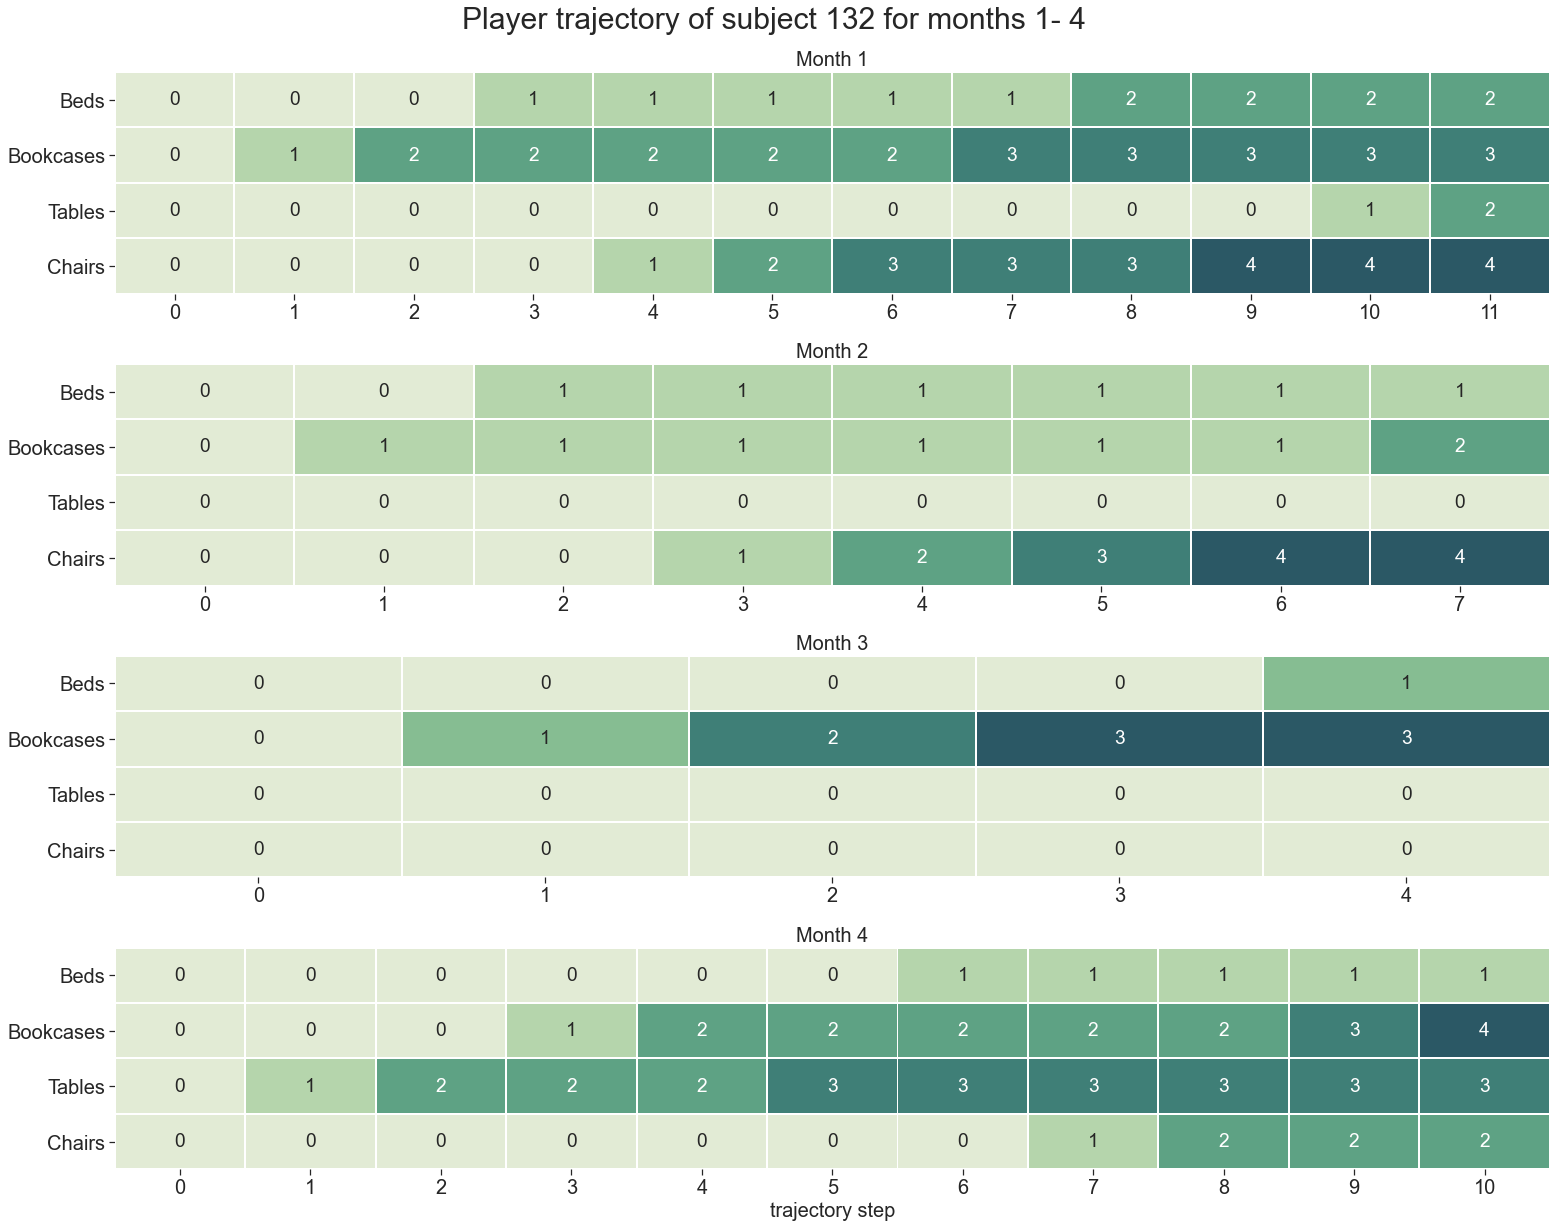

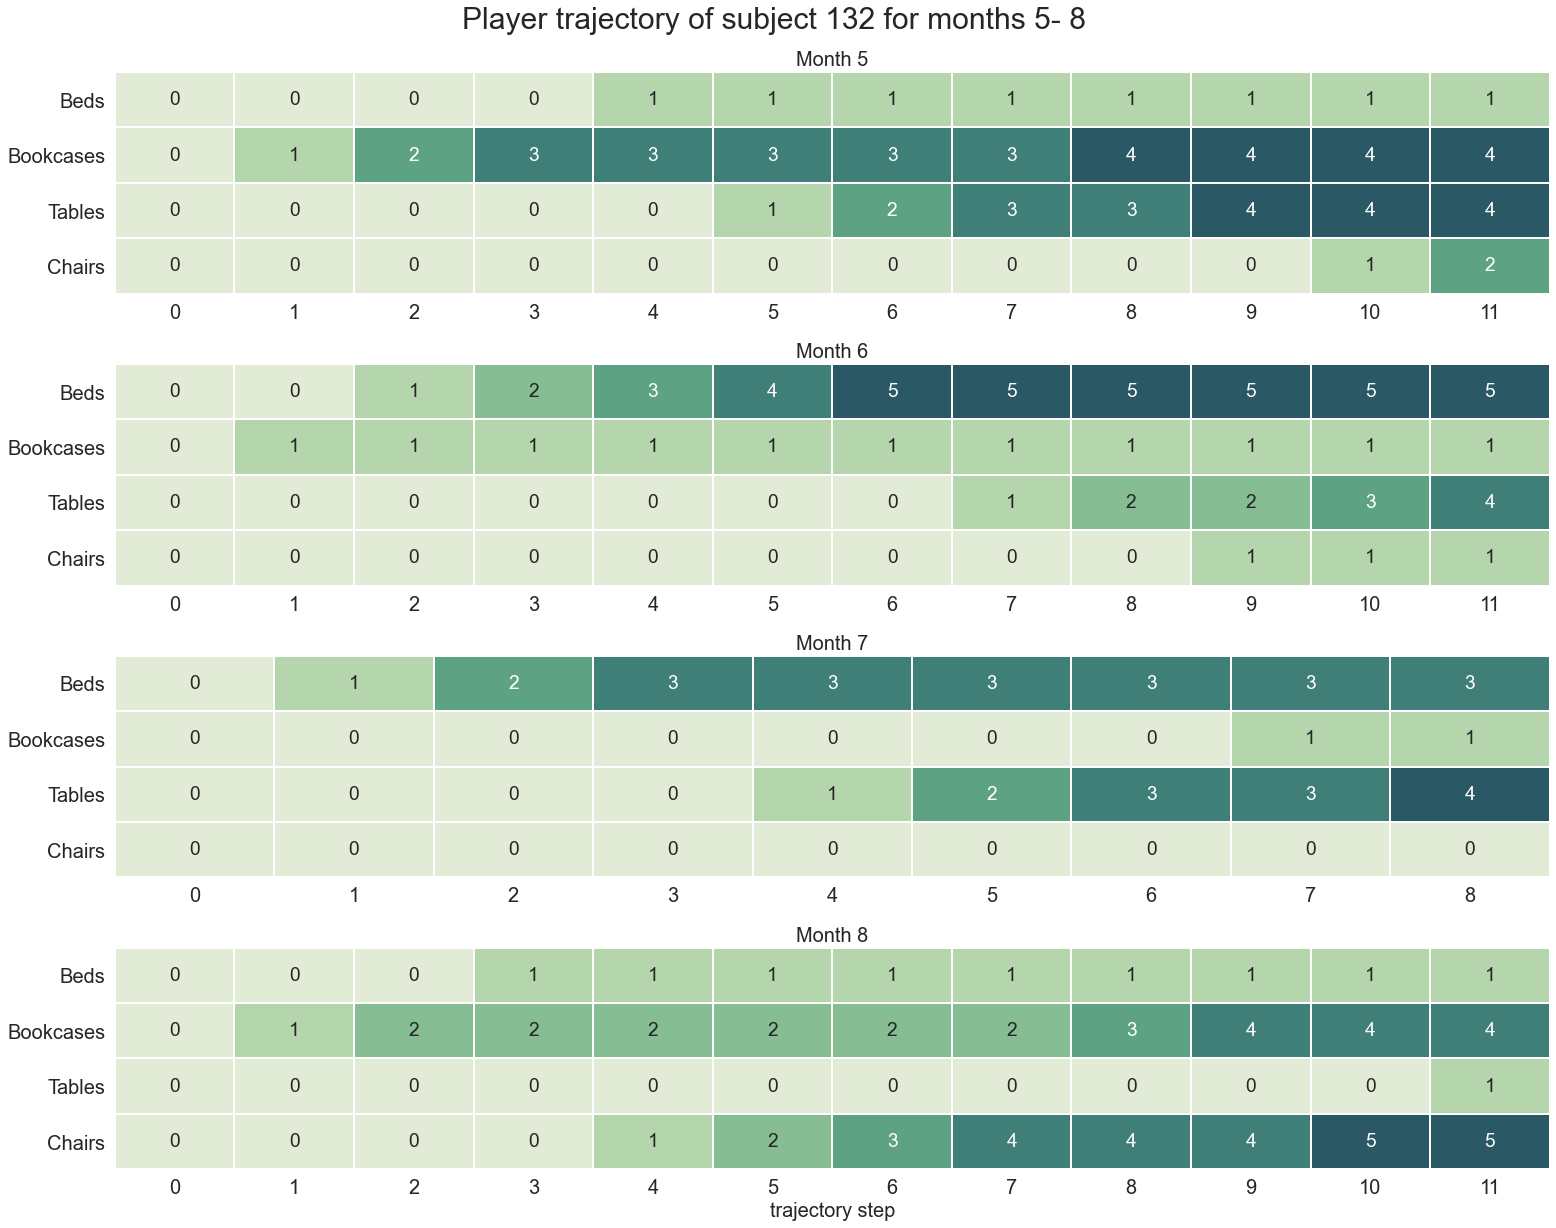

In [16]:

for vp in df_actions.vp.unique():
    directory = 'Images/vp_'+str(vp) + '/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    plot_basic_statistics(vp, df_vp_sol, df_model, df_play_times)
    plt.close()
    plot_general_actions(vp, df_actions)
    plt.close()
    plot_furniture(vp, df_built)
    plt.close()
    plot_furniture_parts(vp, df_built)
    plt.close()
    furniture_overview(vp, df_built)
    plt.close()
    plot_material(vp, df_resources)
    plt.close()
    plot_workshops(vp, df_resources)
    plt.close()
    plot_decision_trajectories(vp, df_solution_paths)
    plt.close()
    break